In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from datetime import datetime
import altair as alt

alt.renderers.enable('notebook') # enable notebook rendering

RendererRegistry.enable('notebook')

In [3]:
features = pd.read_csv('./data/TrainFeatures.csv')
outcome = pd.read_csv('./data/TrainOutcome.csv')

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional
5,9944,functional
6,19816,non functional
7,54551,non functional
8,53934,non functional
9,46144,functional


In [35]:
pd.isnull(features).any()

id                       False
amount_tsh               False
date_recorded            False
funder                    True
gps_height               False
installer                 True
longitude                False
latitude                 False
wpt_name                 False
num_private              False
basin                    False
subvillage                True
region                   False
region_code              False
district_code            False
lga                      False
ward                     False
population               False
public_meeting            True
recorded_by              False
scheme_management         True
scheme_name               True
permit                    True
construction_year        False
extraction_type          False
extraction_type_group    False
extraction_type_class    False
management               False
management_group         False
payment                  False
payment_type             False
water_quality            False
quality_

In [36]:
features.shape

(59400, 40)

In [37]:
na_removed = features.dropna()
na_removed.shape

(27813, 40)

In [38]:
null_indices = features.columns[features.isna().any()].tolist()
for index in null_indices:
    mode = features[index].mode().iloc[0]
    features[index].loc[pd.isnull(features[index])] = mode
    
pd.isnull(features).any()

C:\Users\james\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


id                       False
amount_tsh               False
date_recorded            False
funder                   False
gps_height               False
installer                False
longitude                False
latitude                 False
wpt_name                 False
num_private              False
basin                    False
subvillage               False
region                   False
region_code              False
district_code            False
lga                      False
ward                     False
population               False
public_meeting           False
recorded_by              False
scheme_management        False
scheme_name              False
permit                   False
construction_year        False
extraction_type          False
extraction_type_group    False
extraction_type_class    False
management               False
management_group         False
payment                  False
payment_type             False
water_quality            False
quality_

In [20]:
categorical_indices = features.loc[:, features.dtypes == object].columns.values
continuous_indices = features.loc[:, features.dtypes != object].columns.values
categorical_indices

array(['funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region',
       'lga', 'ward', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source',
       'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group'], dtype=object)

In [24]:
continuous_indices

array(['amount_tsh', 'date_recorded', 'gps_height', 'longitude',
       'latitude', 'num_private', 'region_code', 'district_code',
       'population', 'construction_year'], dtype=object)

We need to disregard id since that will have no predictive power (as an arbitrarily assigned variable). We also need to correctly handle date_recorded by converting it into time since epoch. Region_code and district_code are incorrectly designated as continuous variables but that does not matter since our dependent variable is categorical and so we will be using chi-square tests to assess statistical significance.

In [40]:
# Removing date recorded (will handle later) and id
categorical_indices = categorical_indices[1:]
continuous_indices = continuous_indices[1:]

for index in categorical_indices:
    features[index] = features[index].replace(features[index].unique(), np.arange(len(features[index].unique()))).astype('int')
    print("done with " + index)

done with funder
done with installer
done with wpt_name
done with basin
done with subvillage
done with region
done with lga
done with ward
done with recorded_by
done with scheme_management
done with scheme_name
done with extraction_type
done with extraction_type_group
done with extraction_type_class
done with management
done with management_group
done with payment
done with payment_type
done with water_quality
done with quality_group
done with quantity
done with quantity_group
done with source
done with source_type
done with source_class
done with waterpoint_type
done with waterpoint_type_group


In [22]:
categorical_outcome = outcome['status_group']
categorical_outcome = categorical_outcome.replace(['functional', 'functional needs repair', 'non functional'], [0, 1, 2]).astype('int')
categorical_outcome

0        0
1        0
2        0
3        2
4        0
5        0
6        2
7        2
8        2
9        0
10       0
11       0
12       0
13       0
14       0
15       0
16       2
17       2
18       1
19       0
20       0
21       0
22       1
23       0
24       0
25       1
26       0
27       0
28       2
29       0
        ..
59370    0
59371    2
59372    2
59373    0
59374    0
59375    0
59376    2
59377    2
59378    0
59379    0
59380    2
59381    2
59382    2
59383    0
59384    2
59385    0
59386    0
59387    0
59388    0
59389    0
59390    0
59391    2
59392    2
59393    0
59394    2
59395    0
59396    0
59397    0
59398    0
59399    0
Name: status_group, Length: 59400, dtype: int32

In [23]:
# Converting date_recorded to time since epoch
epoch_time = []

for date in features['date_recorded']:
    date = datetime.strptime(date, '%Y-%m-%d')
    epoch_time.append(date.timestamp())
    
features['date_recorded'] = epoch_time

TypeError: strptime() argument 1 must be str, not float

In [25]:
for index in categorical_indices:
    table = pd.crosstab(features[index], categorical_outcome)
    c, p, dof, expected = chi2_contingency(table.values)
    print(index + ': ' + str(p))
    
for index in continuous_indices:
    table = pd.crosstab(features[index], categorical_outcome)
    c, p, dof, expected = chi2_contingency(table.values)
    print(index + ': ' + str(p))

funder: 0.0
installer: 0.0
wpt_name: 3.167496602060071e-15
basin: 0.0
subvillage: 0.0
region: 0.0
lga: 0.0
ward: 0.0
public_meeting: 2.4094177307380953e-66
recorded_by: 1.0
scheme_management: 0.0
scheme_name: 0.0
permit: 1.9035221956985326e-15
extraction_type: 0.0
extraction_type_group: 0.0
extraction_type_class: 0.0
management: 0.0
management_group: 1.744626138526002e-57
payment: 0.0
payment_type: 0.0
water_quality: 0.0
quality_group: 0.0
quantity: 0.0
quantity_group: 0.0
source: 0.0
source_type: 0.0
source_class: 1.983538119535752e-126
waterpoint_type: 0.0
waterpoint_type_group: 0.0
amount_tsh: 0.0
date_recorded: 0.0
gps_height: 1.935832234019064e-40
longitude: 0.9999988241305058
latitude: 0.9999988211760183
num_private: 1.3700364563899945e-12
region_code: 0.0
district_code: 0.0
population: 1.2004595650770784e-174
construction_year: 0.0


features to use:

- wpt name
- public meeting
- permit
- management group
- source class
- gps height
- num private
- population

In [26]:
column_selector = ['wpt_name', 'public_meeting', 'permit', 'management_group', 'source_class', 'gps_height', 'num_private', 'population']

C:\Users\james\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(0,0.5,'Count of Occurrences')

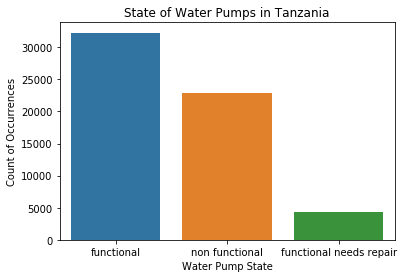

In [27]:
fig, ax = plt.subplots()
fig = sns.countplot(x="status_group", data=outcome)
ax.set_title('State of Water Pumps in Tanzania')
ax.set_xlabel('Water Pump State')
ax.set_ylabel('Count of Occurrences')

C:\Users\james\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(0,0.5,'Count of Occurrences')

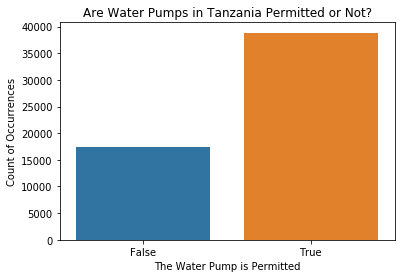

In [35]:
fig, ax = plt.subplots()
fig = sns.countplot(x="permit", data=features)
ax.set_title('Are Water Pumps in Tanzania Permitted or Not?')
ax.set_xlabel('The Water Pump is Permitted')
ax.set_ylabel('Count of Occurrences')

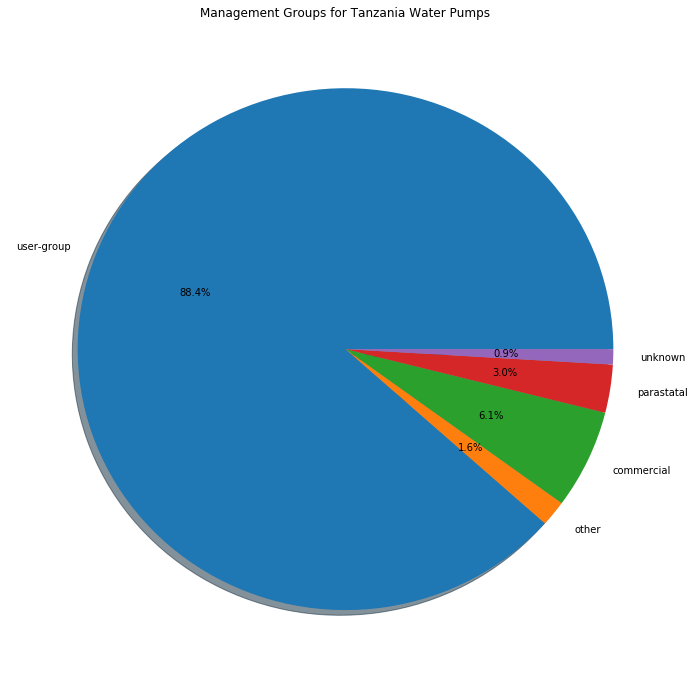

In [48]:
groups = features['management_group'].unique()
sizes = []
for group in groups:
    sizes.append(len(features.loc[features['management_group'] == group]))
fig, ax = plt.subplots()
plt.pie(sizes, labels=groups, autopct='%1.1f%%', shadow=True)
ax.set_title('Management Groups for Tanzania Water Pumps')
fig.set_size_inches(12,12)

parastatal: separate from the government but activities serve the government